# Solution enthalpy calculation
Once we have tested and vetted a way to calculate the Vignet parameters, we can put the code in 'Vignet_parameter_fitting_example.ipynb' into a python script and load it as a module.  This way, we can apply this to many combination of systems easily.  This module is in the file called 'aydin_extract_murnagan.py'.

The solution enthalpy is 
\begin{equation}
    \Delta H_s(\mu_x) = E_{nM-X} - \left(n\mu_{M} + \mu_{X}\right),
\end{equation}
where $E_{nM-X}$ is the energy of the supercell containing $n$ matrix elements and one interstitial element $X$, $\mu_{M}$ is the chemical potential of the matrix element and $\mu_{X}$ is the chemical potential of the interstitial atoms.

Here, we calculate
\begin{equation}
    \Delta E = E_{nM-X} - n\mu_{M},
\end{equation}
for all $32$-atom supecells (fcc) in our dataframe.

In [1]:
import sys as sys
import numpy as np
import pandas as pd
from collections import namedtuple

import aydin_extract_murnagahn as fit

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

In [2]:
# Sane color scheme
Color = namedtuple('Color', ['red', 'blue', 'orange', 'cyan', 'green', 'yellow'])
sol = Color(red='#dc322f', blue='#268bd2', orange='#cb4b16', cyan='#2aa198', 
            green='#859900', yellow='#b58900')

In [3]:
# load data
# Load previously calculated json file
df_all = pd.DataFrame()
df_all = pd.read_json('aydin_data_summary.json')

# Replace missing values with sensible values
df_all['n2'].fillna(0, inplace=True)
df_all['el2'].fillna('None', inplace=True)

## Data exploration

It would be helpful do a bit of data exploration and get a list of matrix elements as well as a list of solute elements.

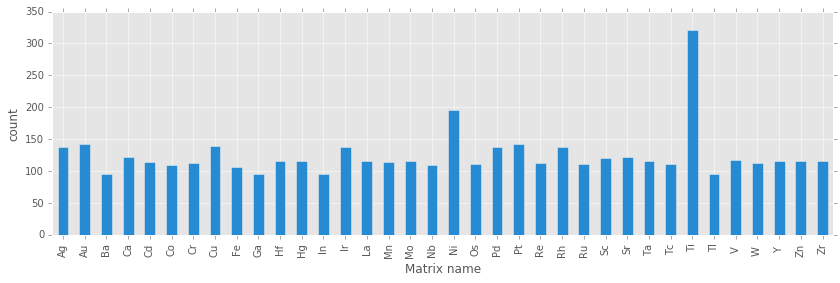

In [4]:
gb = df_all[(df_all.n1==32) & (df_all.n2==1)].groupby('el1')
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)
gb.size().plot(ax=ax, kind='bar', color=sol.blue, figsize=(14,4))
ax.set_xlabel('Matrix name')
ax.set_ylabel('count')

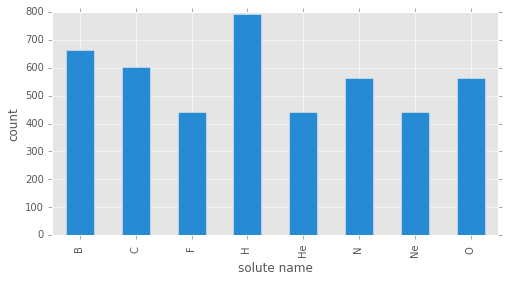

In [5]:
gb = df_all[(df_all.n1==32) & (df_all.n2==1)].groupby('el2')
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)
gb.size().plot(ax=ax, kind='bar', color=sol.blue, figsize=(8,4))
ax.set_xlabel('solute name')
ax.set_ylabel('count')

In [6]:
gb = df_all[(df_all.n1==32) & (df_all.n2==1)].groupby('el1')
matrix_list = [item for item in gb.count().index]
print matrix_list

[u'Ag', u'Au', u'Ba', u'Ca', u'Cd', u'Co', u'Cr', u'Cu', u'Fe', u'Ga', u'Hf', u'Hg', u'In', u'Ir', u'La', u'Mn', u'Mo', u'Nb', u'Ni', u'Os', u'Pd', u'Pt', u'Re', u'Rh', u'Ru', u'Sc', u'Sr', u'Ta', u'Tc', u'Ti', u'Tl', u'V ', u'W ', u'Y ', u'Zn', u'Zr']


In [7]:
gb = df_all[(df_all.n1==32) & (df_all.n2==1)].groupby('el2')
sol_list = [item for item in gb.count().index if item is not 'None']
print sol_list

[u'B ', u'C ', u'F ', u'H ', u'He', u'N ', u'Ne', u'O ']


## Fit Vignet parameters

To make the analysis easier, we write a function that takes the matrix name, the solute name and the list of paramters to be filtered and output a pandas dataframe with the Vignet parameter.  We can use this function on a loop and apply it to two lists we created previously.

The columns of the dataframe are as follows:
- matrix: name of matrix element
- solname: name of interstitial element
- site_type: 'oct' for octahedral site, and 'tet' for tetrahedral site
- E0: $E_0$ Vignet parameter
- V0: $V_0$ Vignet parameter
- B0: $B_0$ Vignet parameter
- B0p: $B_0'$ Vignet parameter
- Delta_E, Delta_V, Delta_B, Delta_Bp: difference between the Vignet parameters of the cells with and without the solute.

In [8]:
def get_vignet(df_all, matrix, solname, params):
    """
        Calculate the Vignet paramters given the matrix, the solute name
        and a list of parameters.
        
        :params:
            df_all - pandas dataframe with all the calculations
            matrix - name of matrix element
            solanme - name of solute element
            params - named tuple containing the parameters to be filtered
            
        :return:
            df - pandas dataframe containing the fitted Vignet parameters 
                 with 2 entries; one for the octahedral site and one for 
                 the tetrahedral site
    """
    # calcualte Vignet parameters
    vignet_oct, vignet_tet, vignet_pure = \
        fit.get_vignet(df_all=df_all, matrix=matrix, solname=solname,
                       n1=params.n1, n2=params.n2, kx=params.kx, 
                       isif=params.isif, cubic=params.cubic, 
                       ismear=params.ismear, magnetic=params.magnetic, 
                       plot=params.plot, verbose=params.verbose)
    
    # initialize dataframe
    df = pd.DataFrame()
    
    # calculate paramters for octahedral site
    E0 = vignet_oct.E0
    V0 = vignet_oct.V0
    B0 = vignet_oct.B0
    B0p = vignet_oct.B0p
    Delta_E = vignet_oct.E0 - vignet_pure.E0
    Delta_V = vignet_oct.V0 - vignet_pure.V0
    Delta_B = vignet_oct.B0 - vignet_pure.B0
    Delta_Bp = vignet_oct.B0p - vignet_pure.B0p
    
    df = df.append(pd.Series([matrix, solname, 'oct', E0, V0, B0, B0p,
                              Delta_E, Delta_V, Delta_B, Delta_Bp, params], 
                             index=['matrix', 'solname', 'site_type', 'E0', 'V0', 
                                    'B0', 'B0p', 'Delta_E', 'Delta_V', 'Delta_B', 
                                    'Delta_Bp', 'params']), ignore_index=True)
    
    # calculate paramters for tetrahedral site
    E0 = vignet_tet.E0
    V0 = vignet_tet.V0
    B0 = vignet_tet.B0
    B0p = vignet_tet.B0p
    Delta_E = vignet_tet.E0 - vignet_pure.E0
    Delta_V = vignet_tet.V0 - vignet_pure.V0
    Delta_B = vignet_tet.B0 - vignet_pure.B0
    Delta_Bp = vignet_tet.B0p - vignet_pure.B0p
    
    df = df.append(pd.Series([matrix, solname, 'tet', E0, V0, B0, B0p,
                              Delta_E, Delta_V, Delta_B, Delta_Bp, params], 
                             index=['matrix', 'solname', 'site_type', 'E0', 'V0', 
                                    'B0', 'B0p', 'Delta_E', 'Delta_V', 'Delta_B', 
                                    'Delta_Bp', 'params']), ignore_index=True)
        
    return df

To keep things neat, we create a named tuple with all the parameters to be filted:
- n1: number of matrix elements in the supercell
- n2: number of interstitial elements in the supercell
- isif: ISIF paramter
- cubic: boolean whether supercell is cubic or not
- ismear: ISMEAR paramter
- magnetic: boolean whether the MAGMOM paramter is in the INCAR or not

We also add some parameters related to visualization and verbosity:
- plot: boolean for creating plots
- verbose: boolean for verbose calculation (progress bar, etc.)

Below, we have made two instances of Params, params_plot for when we want plots and params_silent for when we want to suppress all output.

In [9]:
Params = namedtuple('Params', ['n1', 'n2', 'kx', 'isif', 'cubic', 'ismear', 
                               'magnetic', 'plot', 'verbose'])
params_plot = Params(n1=32, n2=1, kx=8, isif=0, cubic=True, ismear=2, 
                     magnetic=False, plot=True, verbose=False)
params_silent = Params(n1=32, n2=1, kx=8, isif=0, cubic=True, ismear=2, 
                       magnetic=False, plot=False, verbose=False)

It is always good to have a sanity check.  In this case, one may want to look at the Vignet fits to make sure that nothing funny is going on in the fitting process.  In the cell below, we plot the fits for matrix='Pd' for all the solutes in the system.

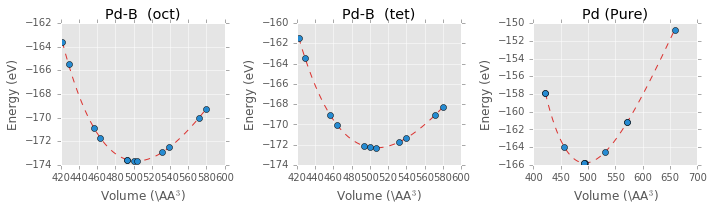

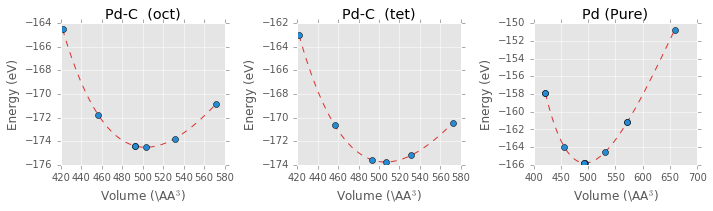

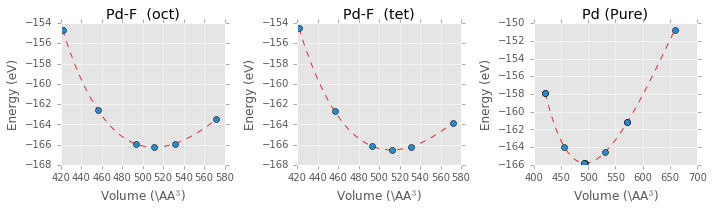

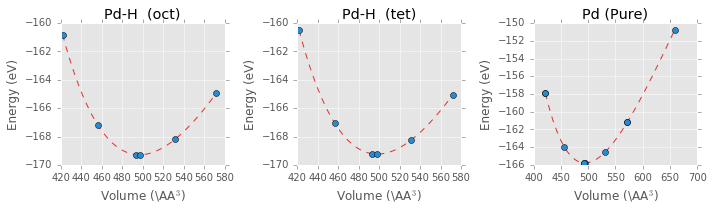

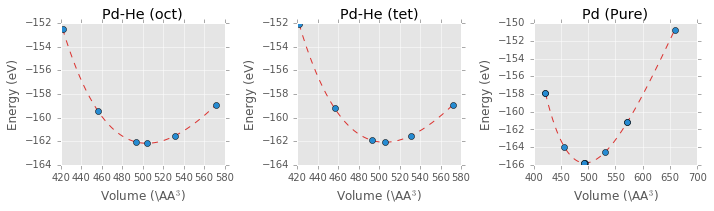

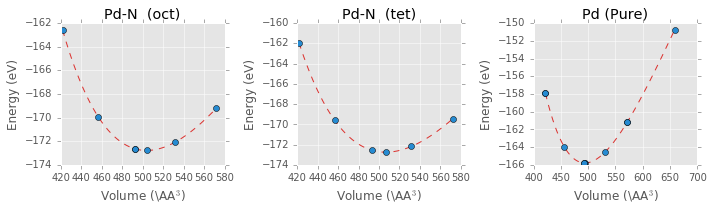

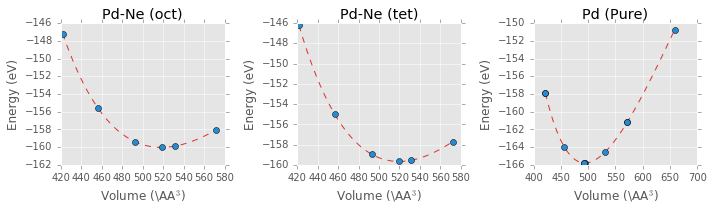

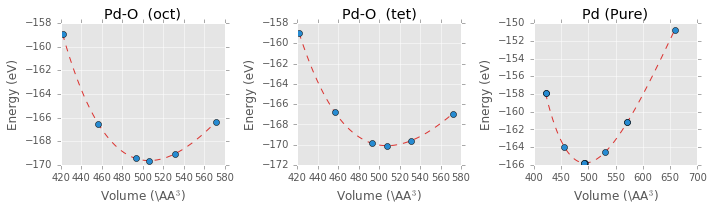

In [10]:
matrix = 'Pd'
dfvignet = pd.DataFrame()

for solname in sol_list:
    dftmp = get_vignet(df_all, matrix, solname, params_plot)
    dfvignet = dfvignet.append(dftmp, ignore_index=True)

In [11]:
dfvignet[['matrix', 'solname', 'site_type', 'E0', 
          'V0', 'B0', 'B0p', 'Delta_E', 'Delta_V']].head()

,matrix,solname,site_type,E0,V0,B0,B0p,Delta_E,Delta_V
0,Pd,B,oct,-173.669024,503.281968,166.391009,5.635440,-7.887530,9.047270
1,Pd,B,tet,-172.313836,506.860629,163.599029,5.622126,-6.532342,12.625931
2,Pd,C,oct,-174.509137,502.952494,166.232077,5.671653,-8.727643,8.717796
3,Pd,C,tet,-173.755635,506.315354,163.492771,5.678649,-7.974141,12.080656
4,Pd,F,oct,-166.254753,510.991042,156.325975,5.716464,-0.473259,16.756345


After this sanity check (one should look at all the plots to make sure that everything is working as intended), we can create a big dataframe containing the Vignet parameters.

In [12]:
dfvignet2 = pd.DataFrame()

for matrix in matrix_list:
    for solname in sol_list:
        sys.stdout.flush()
        sys.stdout.write('\rProcessing ' + matrix + '-' + solname)
        sys.stdout.flush()

        dftmp = get_vignet(df_all, matrix, solname, params_silent)
        dfvignet2 = dfvignet2.append(dftmp, ignore_index=True)
        
# serialize the data for future analysis
dfvignet2.to_json('aydin_vignet_params.json')

Processing Nb-N 

/Users/dagatkarimlan/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Processing Zr-O 

In [13]:
print('Number of rows: {}'.format(len(dfvignet2)))
dfvignet2[['matrix', 'solname', 'site_type', 'E0', 
           'V0', 'B0', 'B0p', 'Delta_E', 'Delta_V']].head()

Number of rows: 576


,matrix,solname,site_type,E0,V0,B0,B0p,Delta_E,Delta_V
0,Ag,B,oct,-94.946910,587.960632,88.977365,5.929565,-4.477368,9.980484
1,Ag,B,tet,-93.902431,593.163526,87.424206,5.886915,-3.432889,15.183379
2,Ag,C,oct,-95.537724,587.926179,88.903063,5.948000,-5.068182,9.946032
3,Ag,C,tet,-94.808836,592.798420,87.517661,5.919639,-4.339294,14.818272
4,Ag,F,oct,-93.368957,596.145803,84.465340,5.932485,-2.899414,18.165656


## Preliminary data exploration of $\Delta E$

Now that we have everything on a dataframe, we can play around with it.  Below are some examples of quick and dirty plots we can do.  A future notebook will contain a much more extensive analysis of the resulting data.

First, I try to see if there is anything interesting between the relationship with the misfit volume Delta_V and Delta_E.

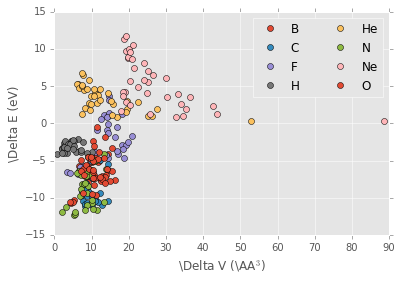

In [14]:
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)

for solname in sol_list:
    mask = (dfvignet2.site_type=='oct') & (dfvignet2.solname==solname) & \
        (dfvignet2.Delta_V>0)
    xvar = dfvignet2[mask].Delta_V.as_matrix()
    yvar = dfvignet2[mask].Delta_E.as_matrix()
    ax.plot(xvar, yvar, 'o', label=solname)
    
ax.legend(loc='best', numpoints=1, ncol=2)
ax.set_xlabel('\Delta V (\AA$^3$)')
ax.set_ylabel('\Delta E (eV)')

We can already see some interesting features in our data.  For example, the regions defined by He and Ne (both noble gases) looks self-similar and markly different from the other interstitials.  However, this plot is perhaps too busy.

We can try creating a plot with a subset of the data with the marker shape corresponding to the matrix and the marker fill corresponding to the interstitial.

In [15]:
matrix_list2 = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu']
sol_list2 = ['H ', 'B ', 'C ', 'N ', 'O ']

# dictionary for marker styles and fills
dict_mstyle = {'Cr': 'o', 'Mn': 's', 'Fe': 'D', 
               'Co': 'v', 'Ni':'^', 'Cu': '<'}
dict_fill = {'H ': sol.red, 'B ': sol.blue, 'C ': sol.yellow, 
             'N ': sol.cyan, 'O ': sol.green}

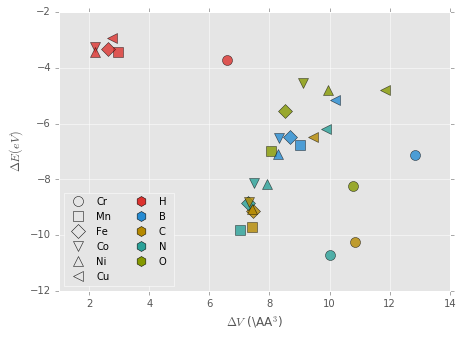

In [16]:
fig = plt.figure(figsize=(7,5))
fig.clf()
ax = fig.add_subplot(111)

for matrix in matrix_list2:
    for solname in sol_list2:
        mask = (dfvignet2.site_type=='oct') & (dfvignet2.matrix==matrix) \
            & (dfvignet2.solname==solname)
        xvar = dfvignet2[mask].Delta_V.as_matrix()
        yvar = dfvignet2[mask].Delta_E.as_matrix()
        
        
        ax.plot(xvar, yvar, marker=dict_mstyle[matrix], 
                markerfacecolor=dict_fill[solname], ms=10, alpha=0.8)
    
# dummy legend hack
for matrix in matrix_list2:
    ax.plot(0, 0, ms=10, marker=dict_mstyle[matrix], 
            markerfacecolor='None', linestyle='None', label=matrix)
    
for solname in sol_list2:
    ax.plot(0, 0, ms=10, marker='h', markerfacecolor=dict_fill[solname], 
            linestyle='None', label=solname)
    
ax.legend(loc=3, numpoints=1, ncol=2, fontsize=10)
ax.set_xlim([1, 14])
ax.set_ylim([-12, -2])

ax.set_xlabel('$\Delta V$ (\AA$^3$)')
ax.set_ylabel('$\Delta E (eV)$')

### Preliminary observations
- Amonst the matrices considered, Cr seems offset in $\Delta V$
- Amonst the interstitials considered, H is clearly an outlier